This notebook calculates the linear SST response to a 1 standard deviation step change in the Southern Annular Mode (SAM). The method is derived from linear convolution theory and is based on a multiple linear regression. For more on the method, see [Kostov et al., 2017](https://link.springer.com/article/10.1007/s00382-016-3162-z). 

$$SST(t) \approx \sum_{i=0}^N G(\tau_i) SAM(t - \tau_i) \Delta \tau + \varepsilon$$

where $\Delta \tau = 1$ year. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import pandas as pd
import psutil
import scipy
import warnings

amon_path = '/scratch/groups/earlew/yuchen/cmip6/piControl/Amon'
omon_path = '/scratch/groups/earlew/yuchen/cmip6/piControl/Omon'
fig_path = '/home/groups/earlew/yuchen/figures'

In [2]:
import scipy.signal

def calculate_sosst(model_name):
    # Get list of files for the model
    files = sorted(glob.glob(f"{omon_path}/tos/tos_Omon_{model_name}_piControl_*.nc"))
    print(f'Found {model_name}...', end=' ')

    # Ignore the warning about multiple fill values
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', 'variable .* has multiple fill values .*')
        if len(files) > 1:
            # Concatenate the time series along the time dimension
            ds = xr.open_mfdataset(files, chunks={'time': 10}, use_cftime=True)
            print('concatenated...', end=' ')
        else: 
            ds = xr.open_dataset(files[0], chunks={'time':10}, use_cftime=True)
            print('dataset retrieved...', end=' ')

    # Identify latitude variable
    for coord in ds.coords:
        if 'units' in ds[coord].attrs:
            if ds[coord].attrs['units'] in ['degrees_north', 'degree_north', 'degree_N', 'degrees_N', 'degreeN', 'degreesN']:
                print(f'found {coord} with units degN... ', end=' ')
                latitude = coord
                break

    # Identify grid dimensions 
    tos_dims = ds['tos'].dims
    non_grid_dims = {'time', 'lev', 'depth', 'bnds'}
    grid_dims = [dim for dim in tos_dims if dim not in non_grid_dims]

    # calculate annual mean and anomaly
    annual_mean = ds['tos'].groupby('time.year').mean('time')
    sst_anomaly = annual_mean - annual_mean.mean('year')

    ### Calculate the Southern Ocean SST index
    mask = (ds[latitude] >= -70) & (ds[latitude] <= -55)
    so_sst_anom = sst_anomaly.where(mask)
    # Get area weights
    weights = np.cos(np.deg2rad(ds[latitude].where(mask)))
    weights = weights.fillna(0) # fill in NaN values
    weights.name = "weights"
    weighted = so_sst_anom.weighted(weights)

    # Area-weighted average
    print('calculating area-weighted average in chunks...', end=' ')
    so_sst_index = None
    for i in range(0, len(ds.time), 10):
        chunk = so_sst_anom.isel(year=slice(i, i+10))
        weighted_chunk = chunk.weighted(weights)
        mean_chunk = weighted_chunk.mean(grid_dims).rename('SO_SST')
        if so_sst_index is None:
            so_sst_index = mean_chunk
        else:
            so_sst_index = xr.concat([so_sst_index, mean_chunk], dim='year')

    # Detrend
    print('loading data and detrending...', end=' ')
    detrended_so_sst_index = xr.apply_ufunc(scipy.signal.detrend, so_sst_index.load(), kwargs={'axis': 0})
    print('done.', end=' ')

    # Save to netCDF
    svdir = '/home/groups/earlew/yuchen/SO_SST'# directory to save to 
    ds_out = detrended_so_sst_index.to_dataset(name='SO_SST')
    ds_out.to_netcdf(f"{svdir}/{model_name}_SOSST_ann_filt.nc")
    print(f'saved! {model_name} done. \n')

    return detrended_so_sst_index


In [3]:
# removed MPI-ESM1-2-HR due to memory issues. See below 
models = ['ACCESS-CM2', 
          'CanESM5', 
          'CESM2',
          'FGOALS-g3', 
          'HadGEM3-GC31-LL', 
          'MIROC6', 
          'MPI-ESM1-2-LR',
          'MRI-ESM2-0']

so_sst_dict = {}
for model in models:
    so_sst_dict[model] = calculate_sosst(model)
    mem = psutil.virtual_memory()
    print(f"Used memory: {mem.used / (1024.0 ** 3)} GB")
    print(f'Avail memory: {mem.available /(1024.0 ** 3)} GB \n')

NameError: name 'calculate_sosst' is not defined

MPI-ESM1-2-HR is calculated separately due to memory issues that kill the kernel. 

In [10]:
model_name = 'MPI-ESM1-2-HR'

# Get list of files for the model
files = sorted(glob.glob(f"{omon_path}/tos/tos_Omon_{model_name}_piControl_*.nc"))
print(f'Found {model_name}...', end=' ')

# Ignore the warning about multiple fill values
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 'variable .* has multiple fill values .*')
    if len(files) > 1:
        # Concatenate the time series along the time dimension
        ds = xr.open_mfdataset(files, chunks={'time': 10}, use_cftime=True)
        print('concatenated...', end=' ')
    else: 
        ds = xr.open_dataset(files[0], chunks={'time':10}, use_cftime=True)
        print('dataset retrieved...', end=' ')

# Identify latitude variable
for coord in ds.coords:
    if 'units' in ds[coord].attrs:
        if ds[coord].attrs['units'] in ['degrees_north', 'degree_north', 'degree_N', 'degrees_N', 'degreeN', 'degreesN']:
            print(f'found {coord} with units degN... ', end=' ')
            latitude = coord
            break

# Identify grid dimensions 
tos_dims = ds['tos'].dims
non_grid_dims = {'time', 'lev', 'depth', 'bnds'}
grid_dims = [dim for dim in tos_dims if dim not in non_grid_dims]

Found MPI-ESM1-2-HR... concatenated... found latitude with units degN...  

In [ ]:
# Split the time series into 100-year chunks and process each separately
n_years_total = len(ds['time.year'])
years_per_chunk = 100 * 12 # Monthly data for 100 years
n_chunks = int(np.ceil(n_years_total / years_per_chunk))

detrended_so_sst_index = None
for k in range(n_chunks):

    start = k * years_per_chunk
    end = start + years_per_chunk

    print(f"Processing years {start//12} to {min(end//12, n_years_total//12)}...")

    # calculate annual mean and anomaly for this chunk of years
    annual_mean = ds['tos'][start:end,:,:].groupby('time.year').mean('time')
    sst_anomaly = annual_mean - annual_mean.mean('year')

    ### Calculate the Southern Ocean SST index
    mask = (ds[latitude] >= -70) & (ds[latitude] <= -55)
    so_sst_anom = sst_anomaly.where(mask)

    # Get area weights
    weights = np.cos(np.deg2rad(ds[latitude].where(mask)))
    weights = weights.fillna(0) # fill in NaN values
    weights.name = "weights"
    weighted = so_sst_anom.weighted(weights)

    # Area-weighted average
    print('Calculating area-weighted average in chunks...', end=' ')
    so_sst_index = None
    for i in range(0, len(so_sst_anom.year), 10):
        chunk = so_sst_anom.isel(year=slice(i, i+10))
        weighted_chunk = chunk.weighted(weights)
        mean_chunk = weighted_chunk.mean(grid_dims).rename('SO_SST')
        mean_chunk = mean_chunk.load()
        print(f'Loaded {i+10} years', end='... ')
        if so_sst_index is None:
            so_sst_index = mean_chunk
        else:
            so_sst_index = xr.concat([so_sst_index, mean_chunk], dim='year')

    # Detrend
    print('Detrending...', end=' ')
    detrended_chunk = xr.apply_ufunc(scipy.signal.detrend, so_sst_index.load(), kwargs={'axis': 0})
    print('Done. \n')

    # Concatenate detrended data
    if detrended_so_sst_index is None:
        detrended_so_sst_index = detrended_chunk
    else:
        detrended_so_sst_index = xr.concat([detrended_so_sst_index, detrended_chunk], dim='year')

# Save to netCDF
ds_out = detrended_so_sst_index.to_dataset(name='SO_SST')
svdir = '/home/groups/earlew/yuchen/SO_SST'# directory to save to 
ds_out.to_netcdf(f"{svdir}/{model_name}_SOSST_ann_filt.nc")
print(f'Saved! {model_name} done. \n')

Processing years 0 to 100...
Calculating area-weighted average in chunks... Loaded 10 years... 

# SAM and SO SST timeseries

In [10]:
## note: excluded MRI since it didn't save properly
models = ['ACCESS-CM2', 
          'CanESM5', 
          'CESM2',
          'FGOALS-g3', 
          'HadGEM3-GC31-LL', 
          'MIROC6', 
          'MPI-ESM1-2-HR', 
          'MPI-ESM1-2-LR',
          'MRI-ESM2-0']

# normalized detrended annual SAM index
sam_dict = {}

# area weighted SO SST index
sst_dict = {}

for model in models:
    sam_dict[model] = xr.open_dataset(f'/home/groups/earlew/yuchen/SAM/{model}_SAM_ann_filt.nc', use_cftime=True)['SAM_filt']
    sst_dict[model] = xr.open_dataset(f'/home/groups/earlew/yuchen/SO_SST/{model}_SOSST_ann_filt.nc', use_cftime=True)['SO_SST']

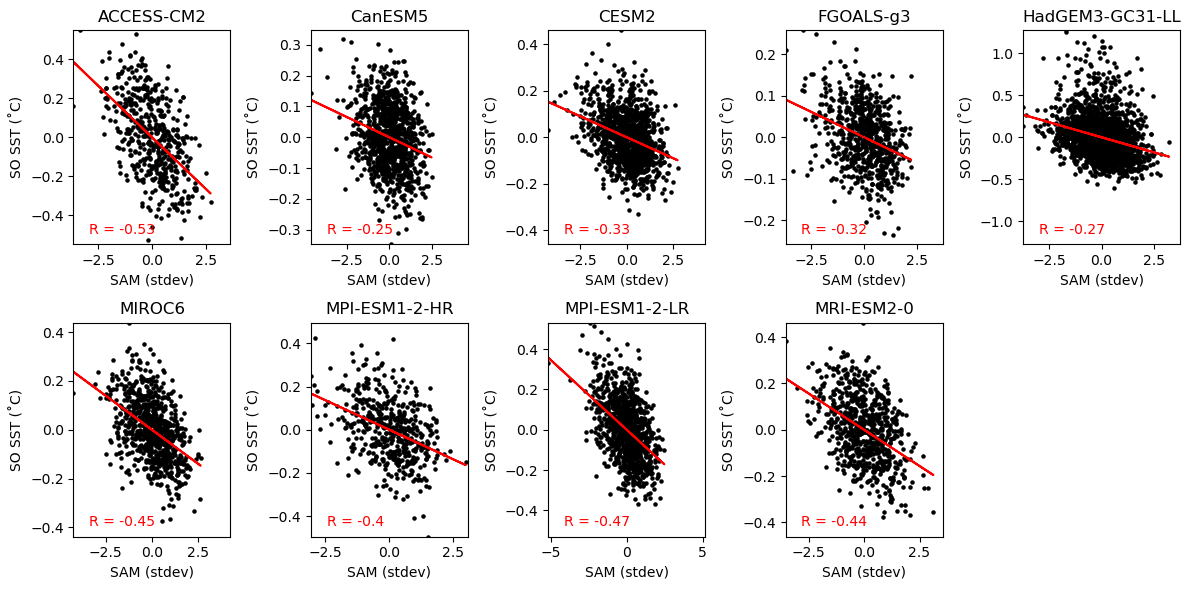

In [11]:
from scipy.stats import linregress
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()

for i,model in enumerate(models):
    ax = axes[i]  # Select the current subplot
    ax.scatter(sam_dict[model], sst_dict[model], color='k', s=5)
    
    # Calculate and plot the line of best fit
    slope, intercept, r_value, _, _ = linregress(sam_dict[model], sst_dict[model])
    ax.plot(sam_dict[model], slope * np.array(sam_dict[model]) + intercept, color='red')

    ax.set_title(model)
    ax.set_xlabel('SAM (stdev)')
    ax.set_ylabel('SO SST (˚C)')
    xlim = max(abs(min(sam_dict[model])), abs(max(sam_dict[model])))
    ylim = max(abs(min(sst_dict[model])), abs(max(sst_dict[model])))
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    
    # Add the correlation coefficient in the corner
    corr_coefficient = round(r_value, 2)
    ax.text(0.1, 0.05, f'R = {corr_coefficient}', transform=ax.transAxes, color='red')


# Remove any unused subplots
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()

# save
plt.savefig(f'{fig_path}/SAM_SST_corr0lag.png', bbox_inches='tight', dpi=300)